In [23]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv('../data/labeled_post.csv')

In [25]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     498 non-null    int64  
 1   title                  498 non-null    object 
 2   body                   498 non-null    object 
 3   subreddit              498 non-null    object 
 4   url                    498 non-null    object 
 5   score                  498 non-null    int64  
 6   num_comments           498 non-null    int64  
 7   upvote_ratio           498 non-null    float64
 8   created_utc            498 non-null    float64
 9   author                 498 non-null    object 
 10  is_original_content    498 non-null    bool   
 11  edited                 498 non-null    bool   
 12  total_awards_received  498 non-null    int64  
 13  gilded                 498 non-null    int64  
 14  search_query           498 non-null    object 
 15  title_

In [36]:
data.drop(['url', 'created_datetime', 'query_category', 'time_to_mvp', 'business_model', 'has_been_labeled'], axis=1, inplace=True)

KeyError: "['url', 'created_datetime', 'query_category', 'time_to_mvp', 'business_model', 'has_been_labeled'] not found in axis"

In [27]:
# Calculate character and word lengths for titles and bodies
title_char_lengths = data['title'].str.len()
title_word_counts = data['title'].str.split().str.len()

body_char_lengths = data['body'].str.len()
body_word_counts = data['body'].str.split().str.len()
text_structure_all = pd.DataFrame({
    'title_char_length': title_char_lengths,
    'title_word_count': title_word_counts,
    'body_char_length': body_char_lengths,
    'body_word_count': body_word_counts}
)

text_structure_all.describe()

,title_char_length,title_word_count,body_char_length,body_word_count
count,498.000000,498.000000,498.000000,498.000000
mean,54.429719,9.391566,3316.058233,529.242972
std,32.671342,5.664788,5628.097999,844.142077
min,2.000000,1.000000,14.000000,2.000000
25%,31.000000,6.000000,802.250000,135.500000
50%,49.000000,9.000000,1582.000000,264.000000
75%,70.000000,12.000000,3384.250000,579.750000
max,277.000000,49.000000,39930.000000,6637.000000


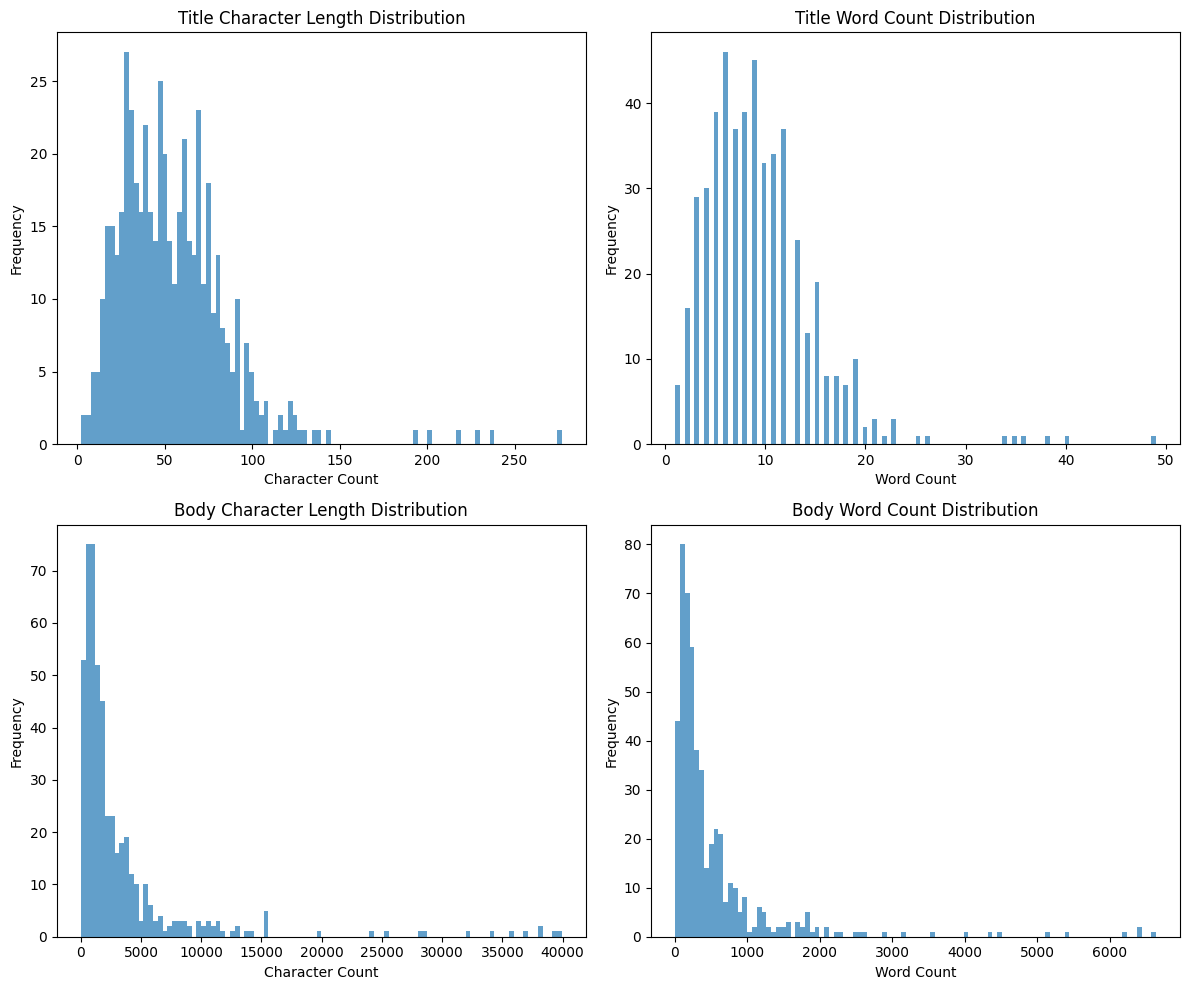

In [29]:
plt.figure(figsize=(12, 10))

# Title length histograms
plt.subplot(2, 2, 1)
plt.hist(title_char_lengths, bins=100, alpha=0.7)
plt.title('Title Character Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(title_word_counts, bins=100, alpha=0.7)
plt.title('Title Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Body length histograms
plt.subplot(2, 2, 3)
plt.hist(body_char_lengths, bins=100, alpha=0.7)
plt.title('Body Character Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(body_word_counts, bins=100, alpha=0.7)
plt.title('Body Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
# Calculate character and word lengths for titles and bodies
title_char_lengths = data[data['market_viability'] == 'Viable']['title'].str.len()
title_word_counts = data[data['market_viability'] == 'Viable']['title'].str.split().str.len()

body_char_lengths = data[data['market_viability'] == 'Viable']['body'].str.len()
body_word_counts = data[data['market_viability'] == 'Viable']['body'].str.split().str.len()
text_structure_positives = pd.DataFrame({
    'title_char_length': title_char_lengths,
    'title_word_count': title_word_counts,
    'body_char_length': body_char_lengths,
    'body_word_count': body_word_counts}
)

text_structure_positives.describe()

,title_char_length,title_word_count,body_char_length,body_word_count
count,99.000000,99.000000,99.000000,99.000000
mean,58.000000,9.646465,2828.585859,436.838384
std,27.761374,5.008795,3450.000278,504.950022
min,10.000000,1.000000,179.000000,34.000000
25%,39.500000,6.000000,808.000000,139.000000
50%,56.000000,9.000000,1580.000000,267.000000
75%,73.500000,13.000000,3242.500000,539.000000
max,134.000000,25.000000,19744.000000,3153.000000


In [47]:
print(len(data.subreddit.unique()))
data.subreddit.value_counts()


449


subreddit
Advice                 6
relationship_advice    5
AITAH                  4
SideProject            3
buildapc               3
                      ..
cinematography         1
Plumbing               1
dndcommissions         1
askapsychologist       1
u_theonlineforyou      1
Name: count, Length: 449, dtype: int64

In [49]:
print(len(data[data['market_viability'] == 'Viable'].subreddit.unique()))
data[data['market_viability'] == 'Viable'].subreddit.value_counts()

96


subreddit
u_YeiXui               2
SaaS                   2
AnalyticsAutomation    2
GetPaidToPlay          1
iphone                 1
                      ..
cryptostudy            1
PlantIdentification    1
productivity           1
Business_Ideas         1
careeradvice           1
Name: count, Length: 96, dtype: int64